In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

torch.cuda.set_per_process_memory_fraction(0.6, 0)
torch.cuda.empty_cache()
torch.manual_seed(1)
torch.cuda.manual_seed(1)

EPOCH = 20
LR = 0.0005
DOWNLOAD_MNIST = False

train_tfm = transforms.Compose([
    transforms.AutoAugment(),
    transforms.RandomAffine(20),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

train_data = torchvision.datasets.MNIST(root='./mnist/', train=True, transform=train_tfm, download=DOWNLOAD_MNIST)
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
print(train_data.data.shape)

train_x = torch.unsqueeze(train_data.data, dim=1).type(torch.FloatTensor) / 255.
train_y = train_data.targets

test_x = torch.unsqueeze(test_data.data, dim=1).type(torch.FloatTensor)[:] / 255.  # Tensor on GPU
test_y = test_data.targets[:]

torch.Size([60000, 28, 28])


/home/doublez/anaconda3/envs/deep_learning/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630841592/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


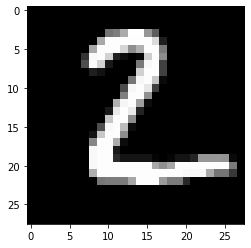

In [2]:
plt.imshow(test_x[1,0,:,:].numpy(), 'gray')
print(test_y[:10])

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Dropout2d(p=0.1),
            torch.nn.MaxPool2d(kernel_size=2),
            

            torch.nn.Conv2d(16, 32, 5, 1, 2), 
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Dropout2d(p=0.2),
            torch.nn.MaxPool2d(2),
            

            torch.nn.Conv2d(32, 64, 5, 1, 2), 
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Dropout2d(p=0.2)
        )
        # self.linear = torch.nn.Linear(32*7*7, 10)
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(64*7*7, 100), 
            torch.nn.BatchNorm1d(100),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(100, 10),
            torch.nn.ReLU()
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        output = x
        return output

model = CNN()
model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

In [4]:
data_size = 20000
batch_size = 100

loss_list = []
acc_list = []

for epoch in range(EPOCH):
    random_indx = np.random.permutation(data_size)
    for batch_i in range(data_size // batch_size):
        model.train()
        indx = random_indx[batch_i * batch_size:(batch_i + 1) * batch_size]

        b_x = train_x[indx, :]
        b_y = train_y[indx]

        output = model(b_x.cuda())
        loss = loss_func(output, b_y.cuda())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch_i % 100 == 0:
            model.eval()
            with torch.no_grad():
                test_output = model(test_x.cuda())
                pred_y = torch.max(test_output, 1)[1].data.squeeze()
                accuracy = torch.sum(pred_y == test_y.cuda()).type(torch.FloatTensor) / test_y.size(0)
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.3f' % accuracy)
                loss_list.append(loss.data.cpu().numpy())
                acc_list.append(accuracy)

Epoch:  0 | train loss: 2.3946 | test accuracy: 0.202
Epoch:  0 | train loss: 0.2626 | test accuracy: 0.965
Epoch:  1 | train loss: 0.1199 | test accuracy: 0.977
Epoch:  1 | train loss: 0.1199 | test accuracy: 0.982
Epoch:  2 | train loss: 0.0608 | test accuracy: 0.984
Epoch:  2 | train loss: 0.0936 | test accuracy: 0.987
Epoch:  3 | train loss: 0.1129 | test accuracy: 0.989
Epoch:  3 | train loss: 0.0747 | test accuracy: 0.987
Epoch:  4 | train loss: 0.0207 | test accuracy: 0.990
Epoch:  4 | train loss: 0.0257 | test accuracy: 0.989
Epoch:  5 | train loss: 0.0515 | test accuracy: 0.988
Epoch:  5 | train loss: 0.0274 | test accuracy: 0.990
Epoch:  6 | train loss: 0.0510 | test accuracy: 0.988
Epoch:  6 | train loss: 0.0357 | test accuracy: 0.991
Epoch:  7 | train loss: 0.0332 | test accuracy: 0.991
Epoch:  7 | train loss: 0.0215 | test accuracy: 0.990
Epoch:  8 | train loss: 0.0130 | test accuracy: 0.991
Epoch:  8 | train loss: 0.0181 | test accuracy: 0.990
Epoch:  9 | train loss: 0.02

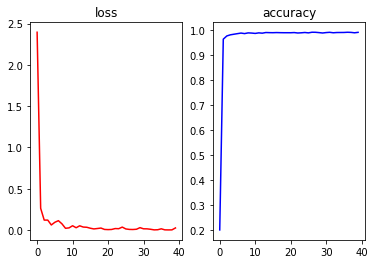

In [5]:
x = np.arange(len(loss_list))
plt.figure()
plt.subplot(1, 2, 1), plt.plot(x, loss_list, 'r', label='loss'), plt.title('loss')
plt.subplot(1, 2, 2), plt.plot(x, acc_list, 'b-', label='accuracy'), plt.title('accuracy')
plt.show()

In [6]:
model.eval()
model.cpu()

test_output = model(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.squeeze()  # move the computation in GPU

print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]) prediction number
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]) real number


tensor([ 0.0000,  0.1897,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 18.3308,
         0.0000,  0.1263], grad_fn=<SelectBackward>)


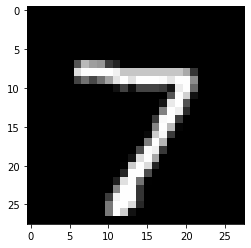

In [7]:
print(test_output[0])
plt.imshow(test_x[:1].numpy().squeeze(), 'gray')